# Ali Flu Project 10x - B cells from FNA Samples from P04, P05 and P11 (Year 1 and Year 2) without integration
* Hailong

In [1]:
## load libraries ####
rm(list=ls())
start_time <- Sys.time()
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("alakazam"))
suppressPackageStartupMessages(library("tidyr"))
suppressPackageStartupMessages(library("gridExtra"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("scales"))
sampleCat = "FNA"
path.work = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
setwd(path.work)
feature.cols = c("lightgray", "blue")

# Load mappings
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
mappings = filter(mappings, SampleType == "FNA")
dim(mappings)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'cowplot' was built under R version 3.6.1"
Warning message:
"package 'alakazam' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"


[1] 47  8

In [2]:
# Read in immunestates file
immunostates_file <- file.path(path.data, "immunostates.txt")
immunostates <- read.table(immunostates_file,header = TRUE,sep="\t") %>%
    gather("KNOWN", "EXPR", -Gene) %>%
    rename(GENE = Gene) %>%
    mutate(EXPR = log(EXPR))

In [3]:
# load saved meta pulled from Ensembl 93 using biomaRt
load(file.path(path.data, "QC_features_meta.RData"))

# CellRanger will always return the same number of features in the GEX matrix 
# as long as the same 10x reference is used 
# In this case, for the reference I used, it's 33538 features
dim(features_meta)
#[1] 33538     5

# biotypes of features
# The IG_ and TR_ ones are the ones to exclude
table(features_meta[["gene_biotype"]])
 
# get a vector of IG and TR genes 
# do this by subsetting $gene_biotype (as opposed to basing off gene names)
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]

[1] 33538     5


      antisense       IG_C_gene IG_C_pseudogene       IG_D_gene       IG_J_gene 
           5497              14               9              37              18 
IG_J_pseudogene       IG_V_gene IG_V_pseudogene         lincRNA  protein_coding 
              3             144             188            7484           19912 
      TR_C_gene       TR_D_gene       TR_J_gene TR_J_pseudogene       TR_V_gene 
              6               4              79               4             106 
TR_V_pseudogene 
             33 

In [5]:
# read in previously generated FNA GEX data and extract only B cells
immune.combined <- readRDS("FNA.GEX.pre_B.Y1Y2.rds")
b_cells = Cells(immune.combined)

## Read in data and apply filters¶

In [6]:
obj_list <- list()
gene_use=c()
for(samplePath in mappings$SamplePath){     
    sample = mappings$SampleName[which(mappings$SamplePath == samplePath)]
    sample2 = mappings$SampleName2[which(mappings$SamplePath == samplePath)]
    sampleType = mappings$SampleType[which(mappings$SamplePath == samplePath)]
    day = mappings$Day[which(mappings$SamplePath == samplePath)]
    subject = mappings$Subject[which(mappings$SamplePath == samplePath)]
    cat(sample, '\n')    
    dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
    cat(dir.name.full, '\n')
    data <- Read10X(data.dir = dir.name.full)
    obj <- CreateSeuratObject(counts = data, project = sample, min.cells = 5, min.features = 400)
    obj$sampleName <- sample
    obj$sampleName2 <- sample2
    obj$sampleType <- sampleType
    obj$day <- day
    obj$subject <- subject   
    obj <- RenameCells(object = obj, add.cell.id = sample)
    
    # Keep only B cells
    cat('There are', length(Cells(obj)), 'cells before filtering\n')     
    obj <- subset(obj, cells = grep(sample, b_cells, value=TRUE))
    cat('There are', length(Cells(obj)), 'cells after filtering\n') 
    
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    gene.cutoff.high=7000
    obj <- subset(x = obj, subset = nFeature_RNA > 400 & nFeature_RNA < gene.cutoff.high & percent.mt < 15)
  
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", scale.factor = 10000)
    obj_list[[sample]] <- obj
    
}


P04_FNA_d0_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_FNA-lib1/outs/filtered_feature_bc_matrix 
There are 5342 cells before filtering
There are 1893 cells after filtering
P04_FNA_d0_2_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_FNA_2-lib1/outs/filtered_feature_bc_matrix 
There are 5084 cells before filtering
There are 1802 cells after filtering
P04_FNA_d0_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_FNA-lib1/outs/filtered_feature_bc_matrix 
There are 4938 cells before filtering
There are 1804 cells after filtering
P04_FNA_d0_2_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_FNA_2-lib1/outs/filtered_feature_bc_matrix 
There are 4540 cells before filtering
There are 1716 cells after filtering
P04_FNA_d5_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d5_FNA-lib1/outs/filtered_feature_bc_matrix 
There are 3870 cells before filter

## Read in data and apply filters¶

In [7]:
samples = mappings$SampleName
samples.left = samples[-c(1,2)]
immune.combined <- merge(obj_list[[samples[1]]] , obj_list[[samples[2]]])
for(sample in samples.left){
    immune.combined <- merge(immune.combined ,  obj_list[[sample]])
}
# remove obj_list & obj & data to save space
rm(obj)
rm(data)
rm(obj_list)
gc()
saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,"_pre.GEX.rds")))

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   2339955  125.0    4252585   227.2    4064310   217.1
Vcells 483928152 3692.1 2905980132 22170.9 5674901907 43296.1

## Number of cells in each sample after filtering

In [8]:
cell.count = as.matrix(table(Idents(immune.combined)))
colnames(cell.count) = "Cell Count"
cell.count

Cell Count
P04_FNA_d0_1_Y1   1893      
P04_FNA_d0_1_Y2   1804      
P04_FNA_d0_2_Y1   1802      
P04_FNA_d0_2_Y2   1716      
P04_FNA_d12_1_Y1  2048      
P04_FNA_d12_2_Y1  1805      
P04_FNA_d120_1_Y1 2349      
P04_FNA_d120_2_Y1 2482      
P04_FNA_d14_1_Y2  1343      
P04_FNA_d14_2_Y2  1442      
P04_FNA_d5_1_Y1   2198      
P04_FNA_d5_2_Y1   3515      
P04_FNA_d60_1_Y2  1034      
P04_FNA_d60_2_Y2  2007      
P04_FNA_d90_1_Y2  2207      
P04_FNA_d90_2_Y2  2708      
P05_FNA_d0_1_Y1   2017      
P05_FNA_d0_1_Y2   1489      
P05_FNA_d0_2_Y1   2112      
P05_FNA_d0_2_Y2   1214      
P05_FNA_d0_3_Y2   1455      
P05_FNA_d12_1_Y1  2981      
P05_FNA_d12_2_Y1  2328      
P05_FNA_d12_3_Y1  2817      
P05_FNA_d120_1_Y2 1736      
P05_FNA_d120_2_Y2 1619      
P05_FNA_d120_3_Y2 1725      
P05_FNA_d120_4_Y2 1837      
P05_FNA_d180_1_Y1 3012      
P05_FNA_d180_2_Y1 1923      
P05_FNA_d28_1_Y2  3132      
P05_FNA_d28_2_Y1  1876      
P05_FNA_d28_2_Y2  3165      
P05_FNA_d28_3_Y1  1929      
P05_FNA_d28_3_Y2  2938      
P05_FNA_d5_1_Y1   3215      
P05_FNA_d5_2_Y1   2524      
P05_FNA_d60_1_Y1  2805      
P05_FNA_d60_1_Y2  1445      
P05_FNA_d60_2_Y1  2839      
P05_FNA_d60_2_Y2  1606      
P05_FNA_d60_3_Y2  1391      
P05_FNA_d7_1_Y2   1694      
P05_FNA_d7_2_Y2   1708      
P05_FNA_d7_3_Y2   1596      
P05_FNA_d90_1_Y1  1456      
P05_FNA_d90_2_Y1  1579

After remvoing IG/TR genes, total gene count is:  1728 


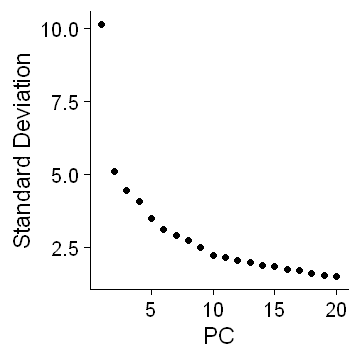

In [9]:
# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(object = immune.combined, verbose = FALSE)
immune.combined <- FindVariableFeatures(immune.combined, selection.method = "vst", nfeatures = 2000, do.plot = F)
bool.remove.genes <- immune.combined@assays$RNA@var.features %in% remove.genes
immune.combined@assays$RNA@var.features = immune.combined@assays$RNA@var.features[!bool.remove.genes]                     
cat('After remvoing IG/TR genes, total gene count is: ', length(immune.combined@assays$RNA@var.features), '\n')
immune.combined <- RunPCA(object = immune.combined, npcs = 30, verbose = FALSE)
options(repr.plot.width=3, repr.plot.height=3)
ElbowPlot(object = immune.combined)

In [10]:
#### UMAP and Clustering
immune.combined <- RunUMAP(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.7)
if(0){immune.combined$sampleName = factor(immune.combined$sampleName, 
        levels = c('P04_FNA_0_Y1', 'P04_FNA_2_0_Y1', 'P04_FNA_5_Y1', 'P04_FNA_2_5_Y1', 
                    'P04_FNA_12_Y1', 'P04_FNA_2_12_Y1', 'P04_FNA_120_Y1', 'P04_FNA_2_120_Y1',
                   
                    'P05_FNA_0_Y1','P05_FNA_2_0_Y1','P05_FNA_5_Y1','P05_FNA_2_5_Y1',
                    'P05_FNA_12_Y1','P05_FNA_2_12_Y1','P05_FNA_3_12_Y1','P05_FNA_2_28_Y1',
                    'P05_FNA_3_28_Y1','P05_FNA_60_Y1','P05_FNA_2_60_Y1','P05_FNA_90_Y1',
                    'P05_FNA_2_90_Y1','P05_FNA_180_Y1','P05_FNA_2_180_Y1') )
immune.combined$sampleName2 = factor(immune.combined$sampleName2, 
        levels = c('P04_FNA_0_Y1',  'P04_FNA_5_Y1', 'P04_FNA_12_Y1', 'P04_FNA_120_Y1', 
                  
                    'P05_FNA_0_Y1','P05_FNA_5_Y1','P05_FNA_12_Y1','P05_FNA_28_Y1',
                    'P05_FNA_60_Y1','P05_FNA_90_Y1','P05_FNA_180_Y1'
                  ) )
      }

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 97516
Number of edges: 2590104

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8789
Number of communities: 22
Elapsed time: 48 seconds


1 singletons identified. 21 final clusters.



In [11]:
#object.size(immune.combined)
#str(immune.combined)

In [12]:
#options(repr.plot.width=6, repr.plot.height=3.5)
# visualize results of CCA plot CC1 versus CC2 and look at a violin plot
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleName")

In [13]:
#options(repr.plot.width=6, repr.plot.height=5)
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleType", split.by="sampleType")

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


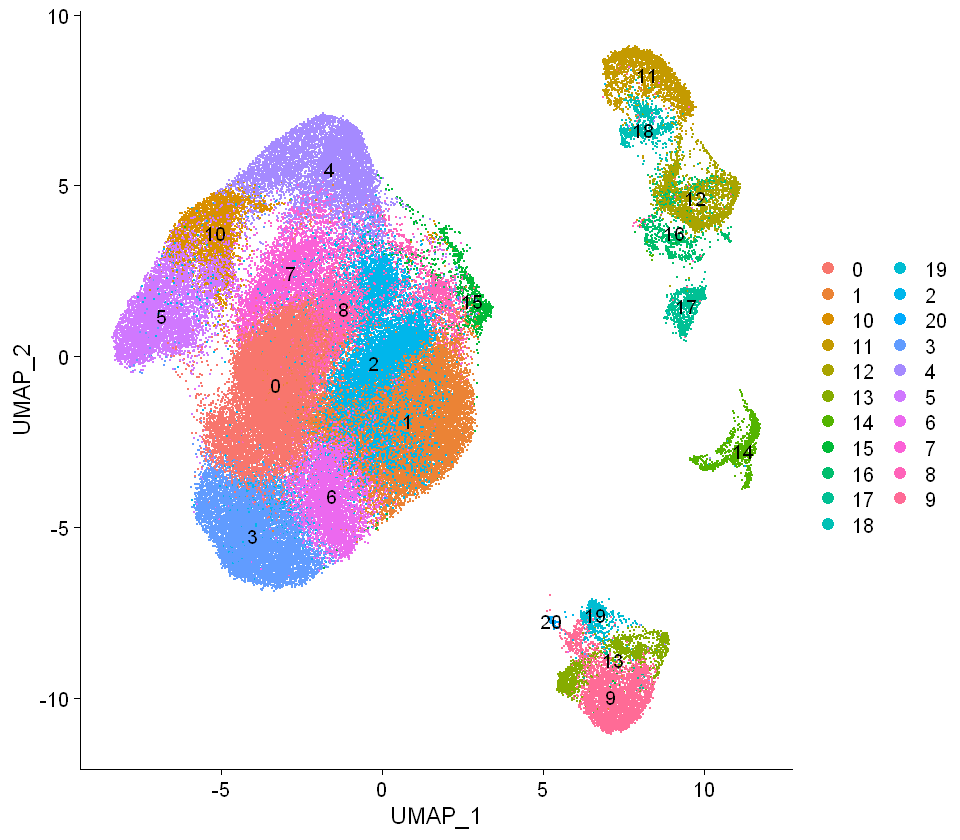

In [14]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE)

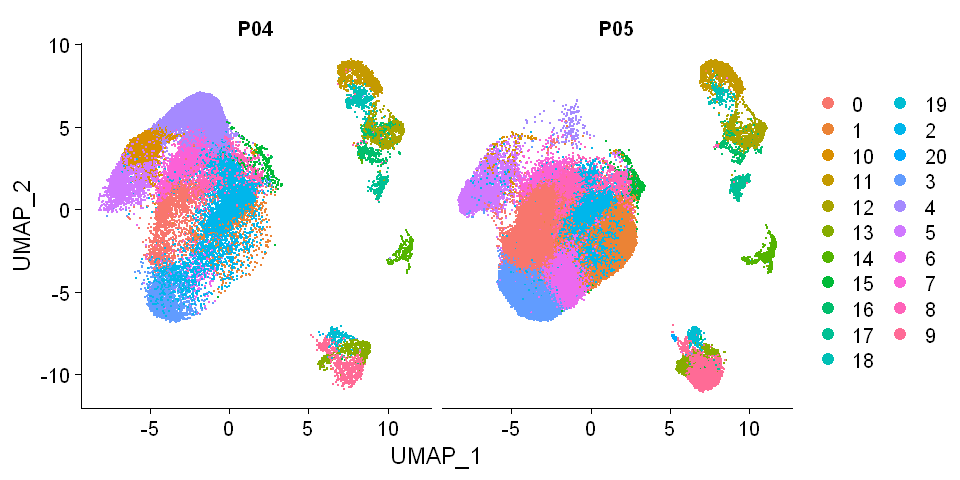

In [15]:
options(repr.plot.width=8, repr.plot.height=4)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")

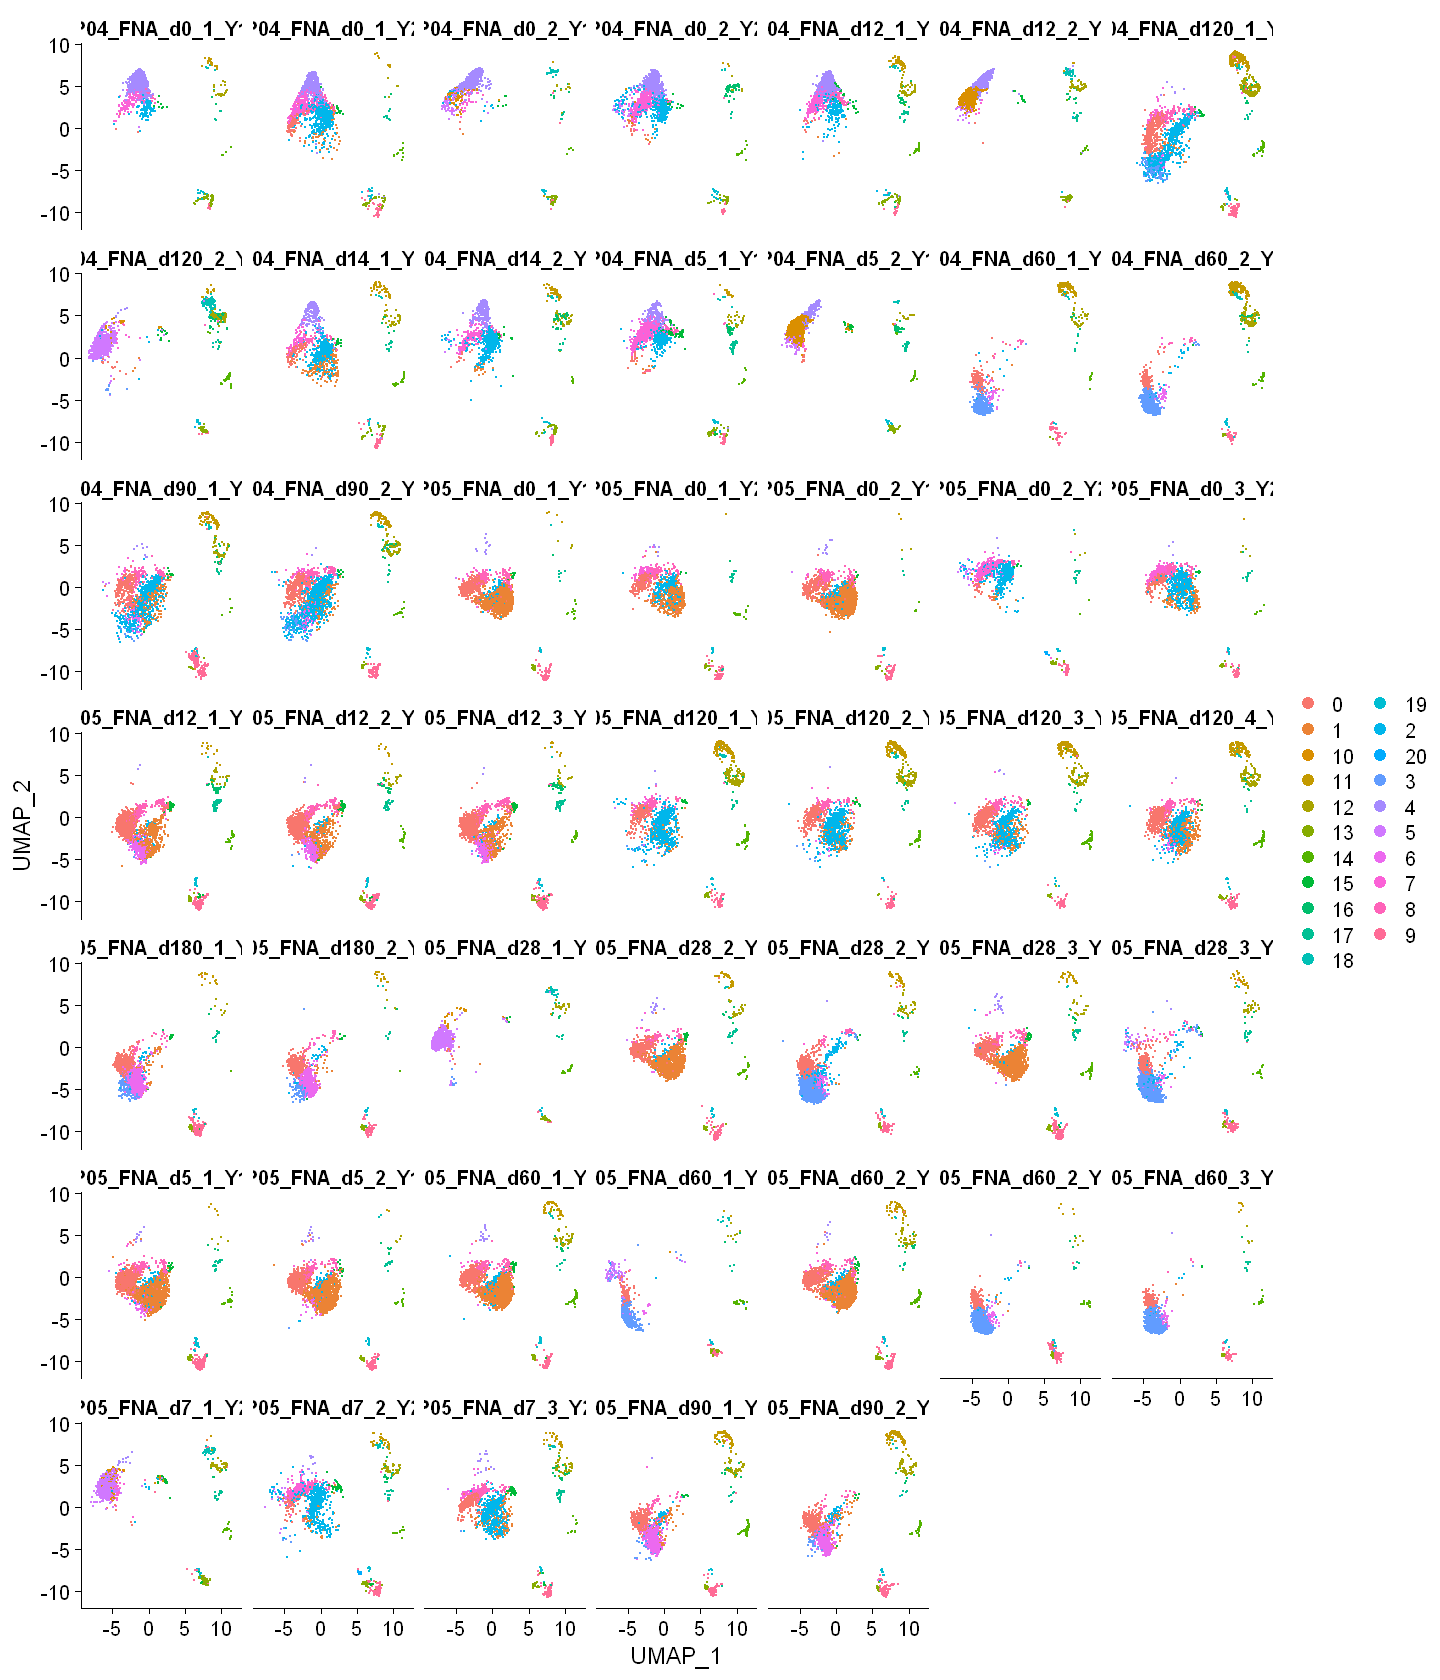

In [16]:
options(repr.plot.width=12, repr.plot.height=14)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName")

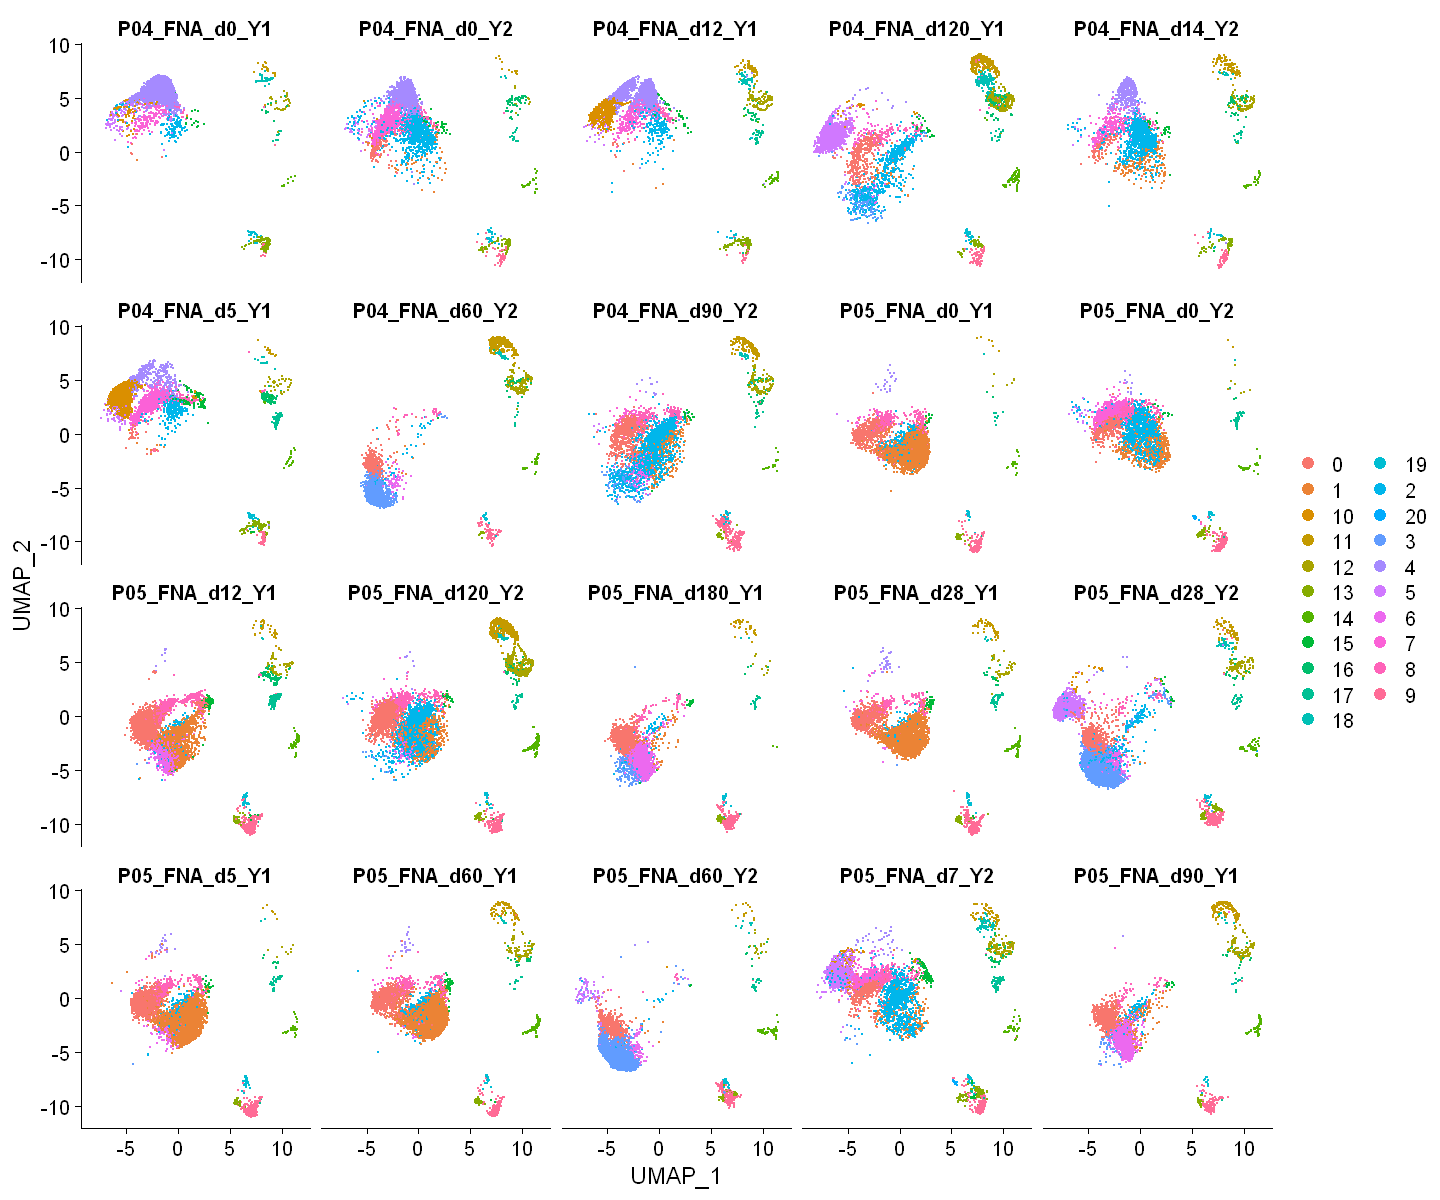

In [17]:
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName2")

## Check marker genes

In [18]:
B <- c("MS4A1", "IGKC","CD79A", "CD79B", "CD19")
RMB <- c("TNFRSF13B", "CD27", "CD24") #Resting Memory B
naive.B <- c("TCL1A", "IL4R",  "CCR7", "IGHM", "IGHD") #Naive B
plasma <- c("CD38", "CD27","FKBP11","TRIB1","SDC1","XBP1", "IRF4", "SEC11C", "JCHAIN", "PRDM1")
GC.B <- c("BCL6", "RGS13", "MEF2B", "STMN1", "ELL3", "SERPINA9")
ABC <- c("TBX21", "FCRL5", "ITGAX", "NKG7", "ZEB2", "CR2")# the lack of CR2 for activated B cells (ABCs);
T <- c("CD3D", "CD3E","CD4", "IL7R", "CD8A")
NK <- c("GZMB", "GNLY", "NKG7", "NCAM1")
CD14.Monocyte <-c("CD14","LYZ")
DC <- c("FCER1A", "CST3")
platlet <- "PPBP"
dividing  <- c("MKI67", "CDK1") # Dividing cells 
  
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC, T, NK, CD14.Monocyte, DC, platlet, dividing))
            

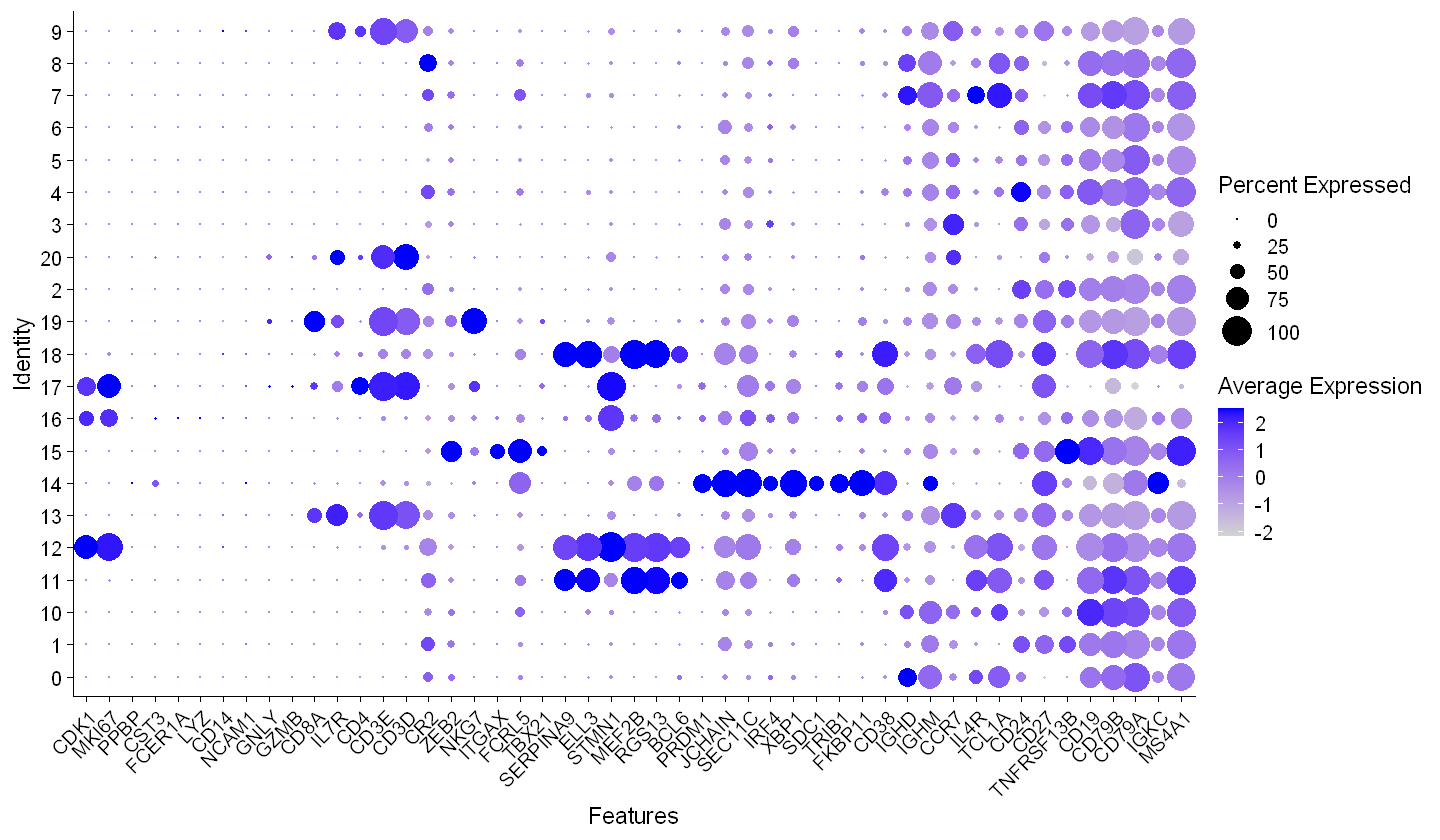

In [19]:
options(repr.plot.width=12, repr.plot.height=7)
DotPlot(immune.combined, assay = "RNA", features =  unique(all.markers), dot.scale = 8) + RotatedAxis()

### B cell markers

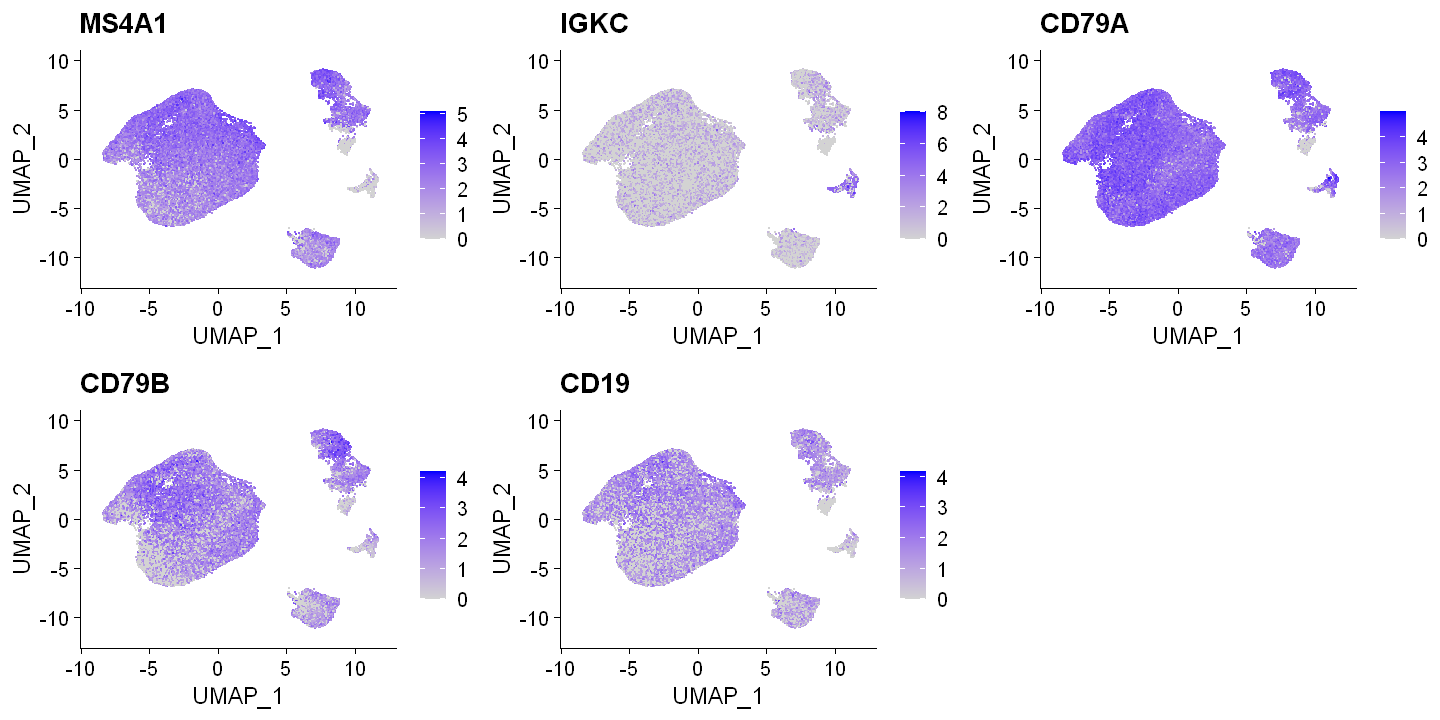

In [20]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Plasma markers

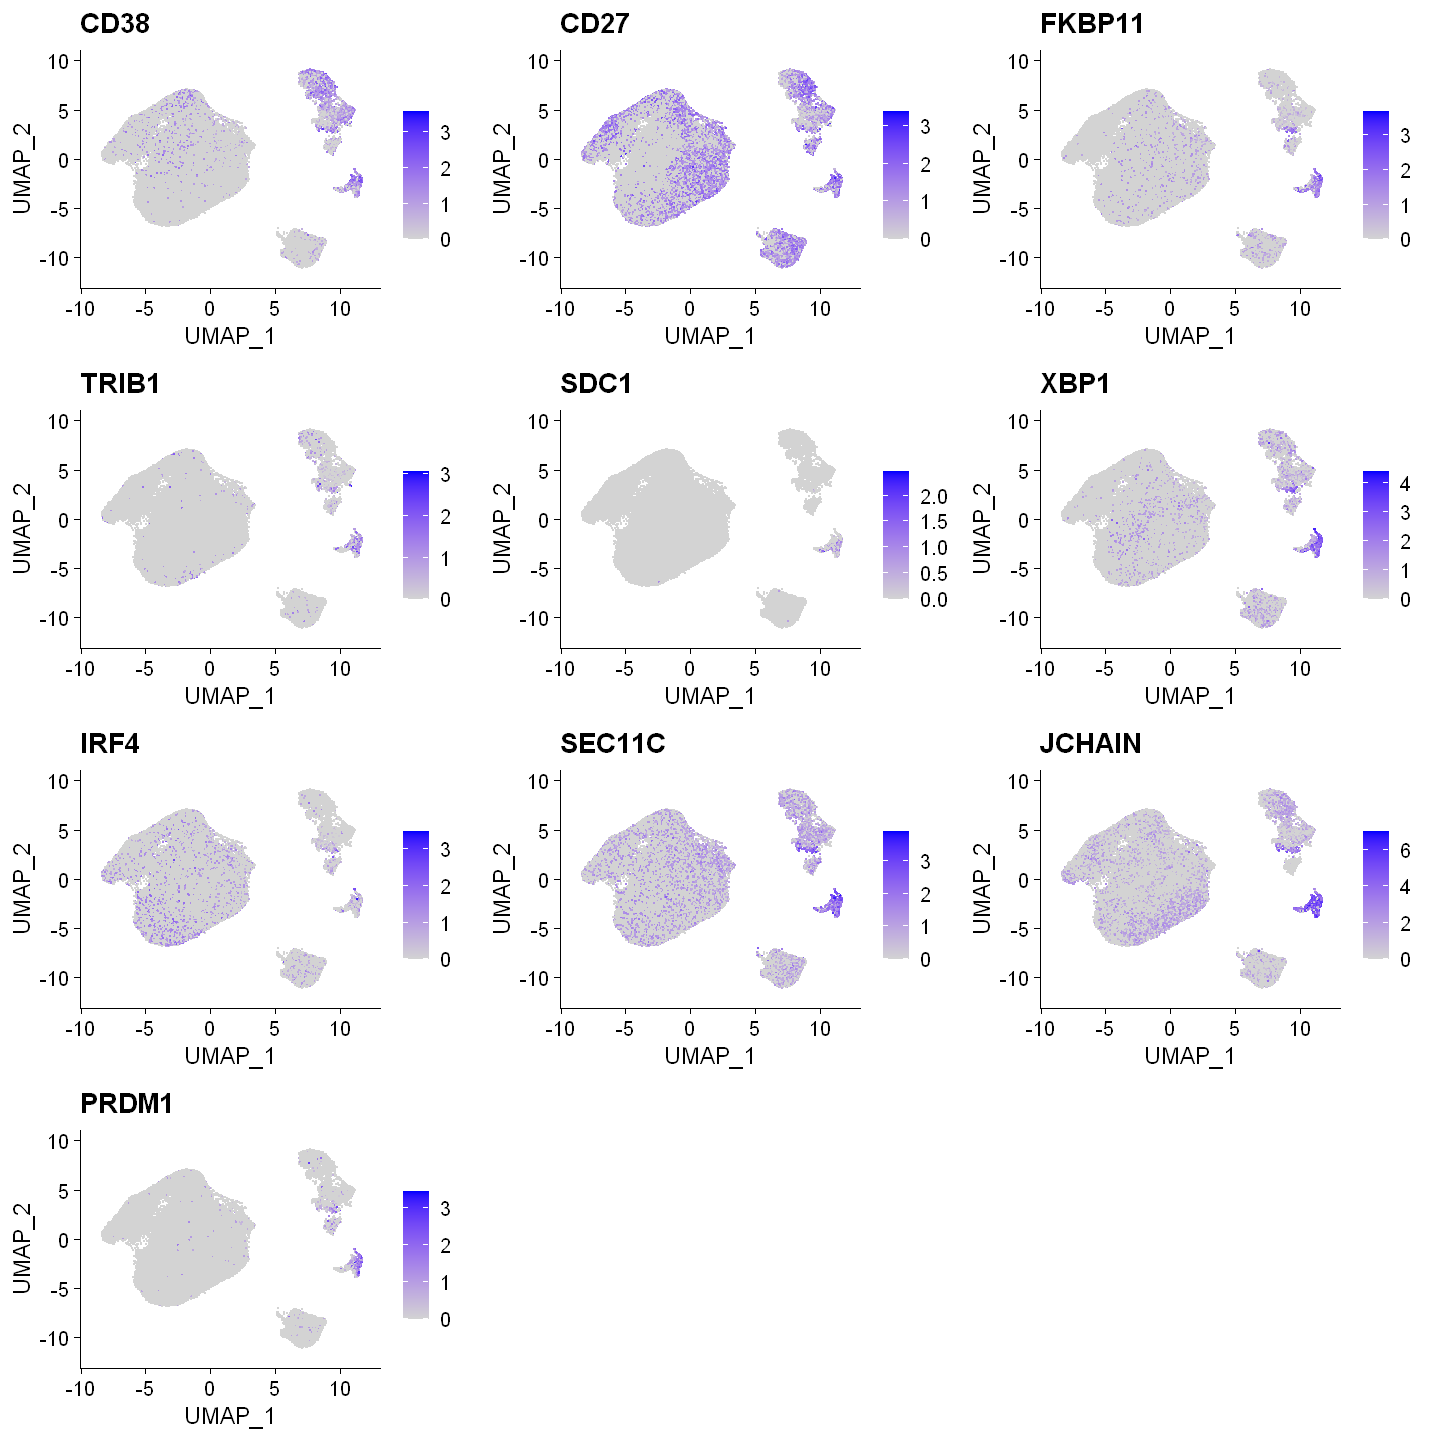

In [21]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(object = immune.combined, features = plasma, ncol =3,cols = feature.cols, min.cutoff = 0)

### Resting Memory B cells

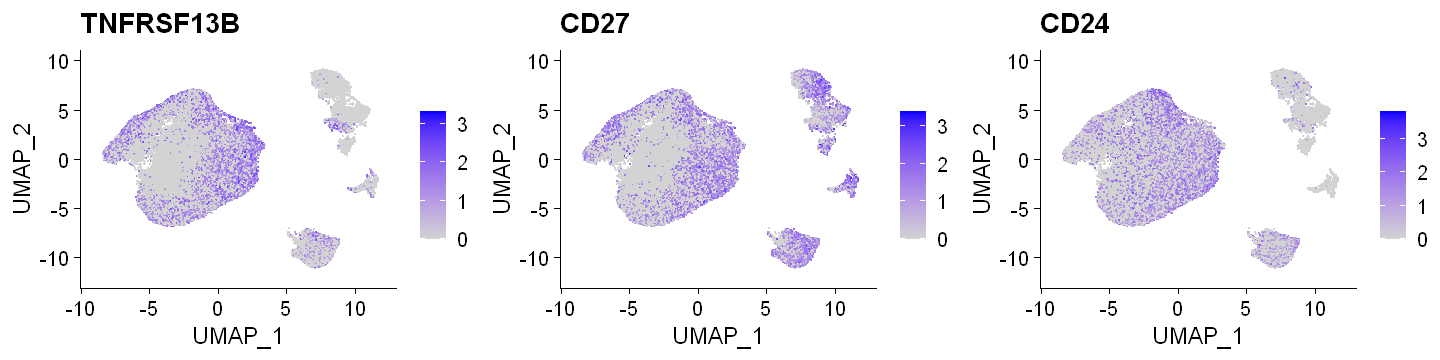

In [22]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = RMB, ncol =3,cols = feature.cols, min.cutoff = 0)

### Naive B cells

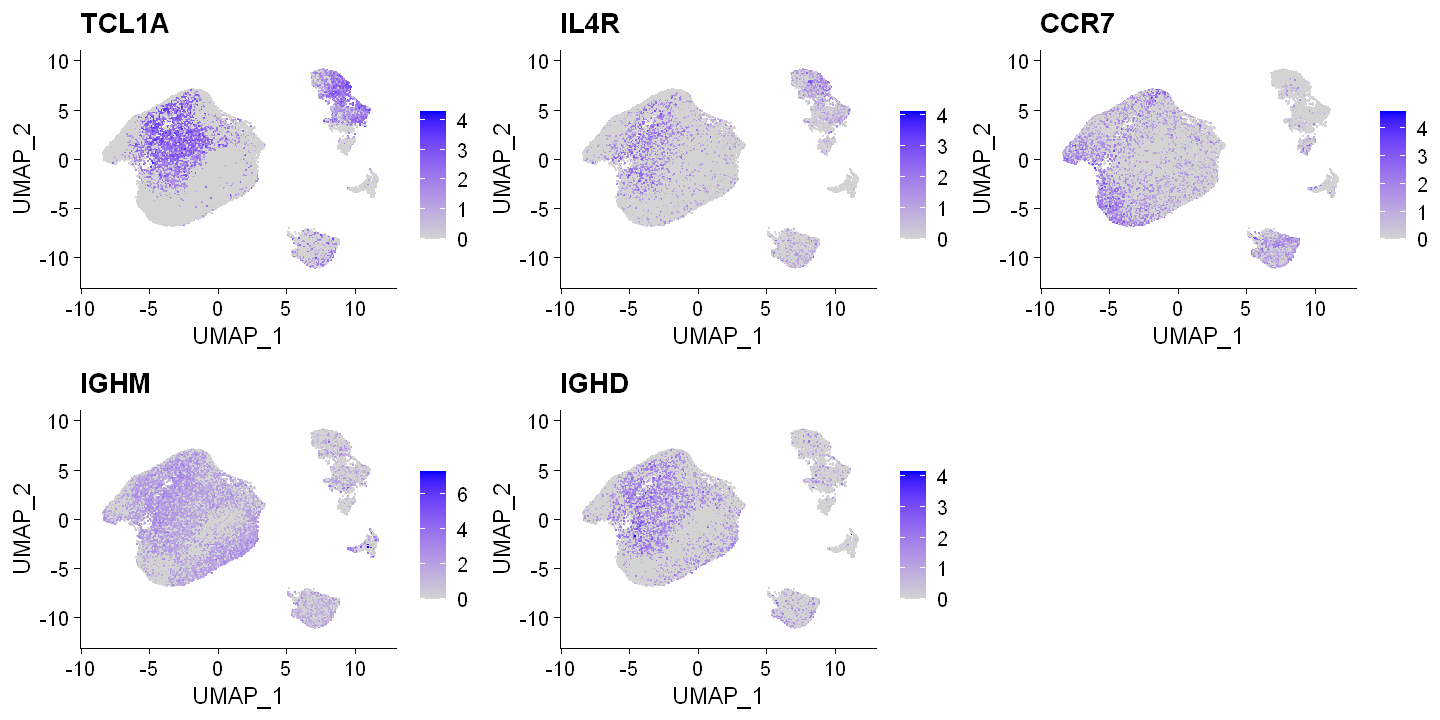

In [23]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = naive.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Germinal Center B cells

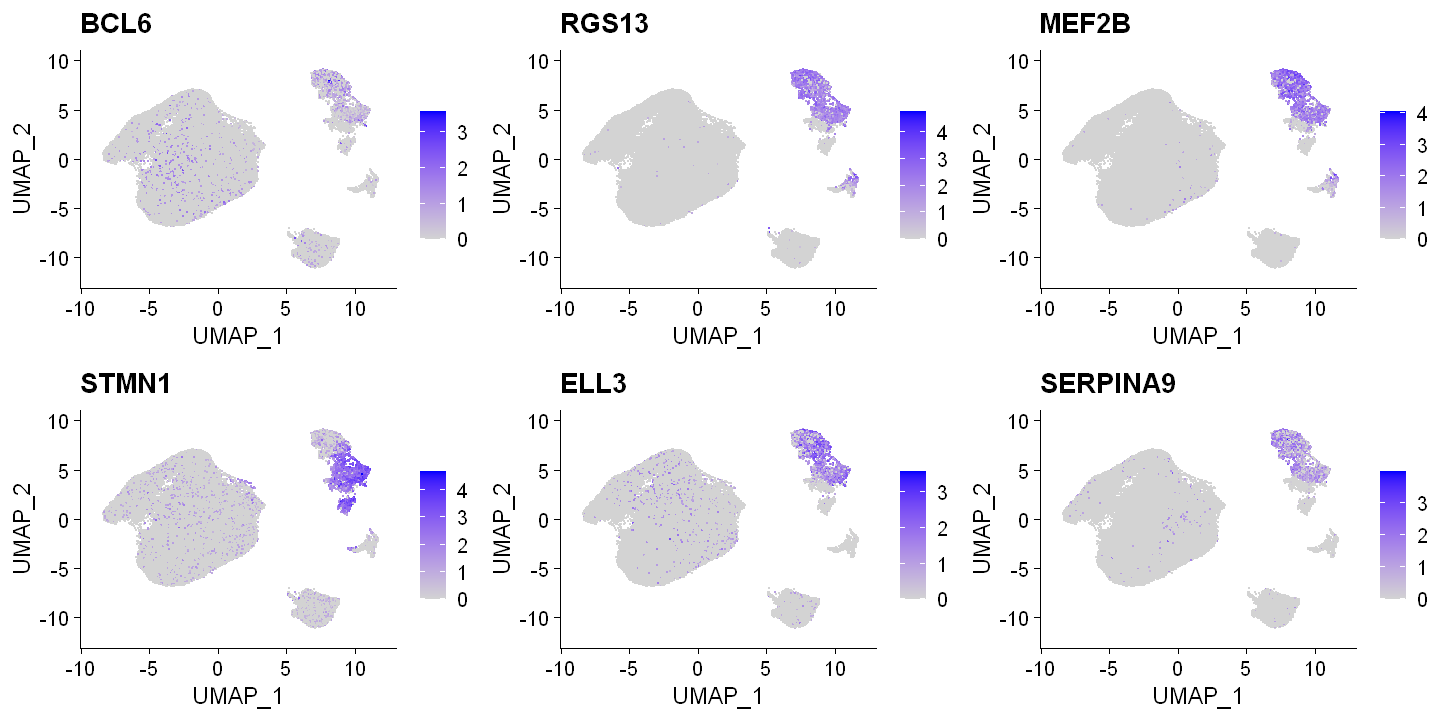

In [24]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = GC.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Activated B cells

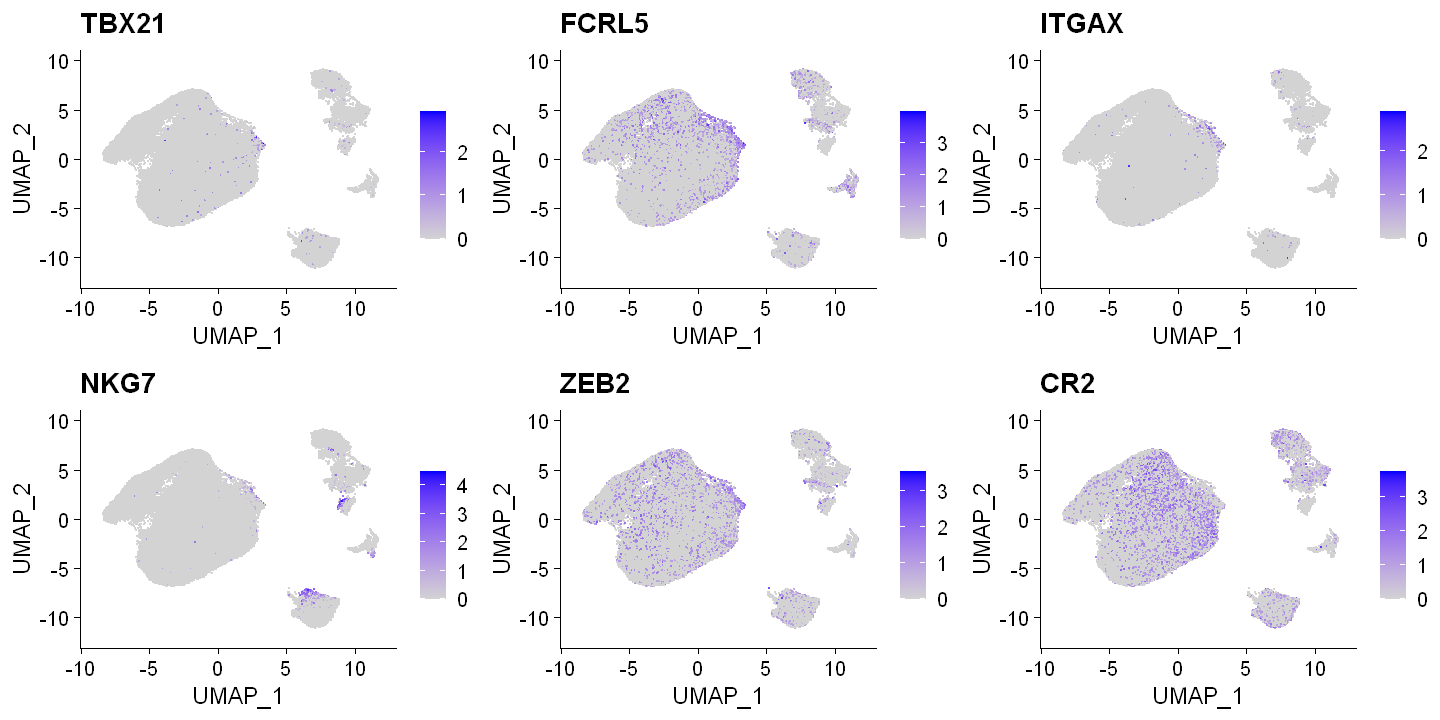

In [25]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = ABC, ncol =3,cols = feature.cols, min.cutoff = 0)

### T cell markers

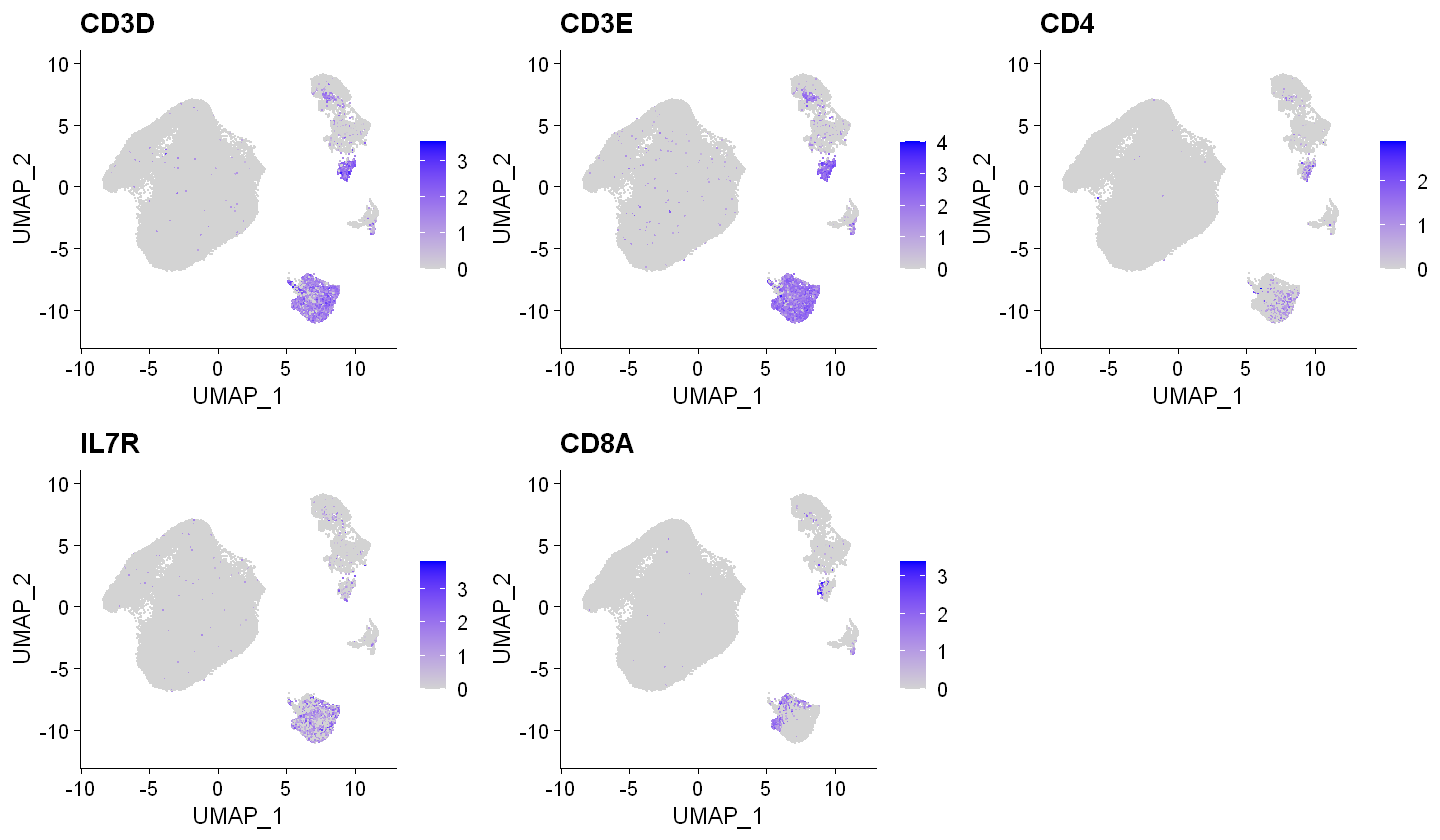

In [26]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = T, ncol =3,cols = feature.cols, min.cutoff = 0)

### NK cell markers

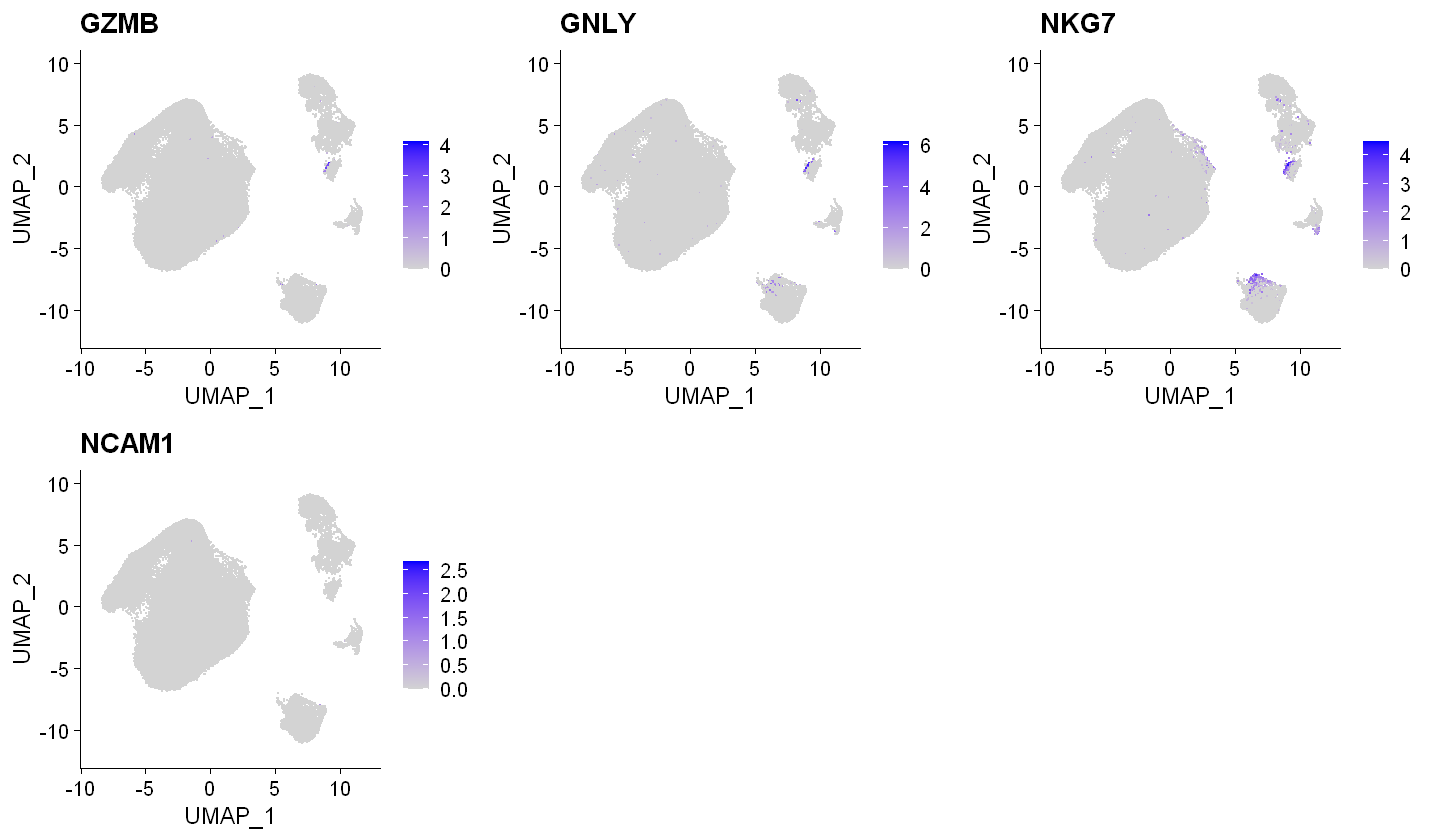

In [27]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = NK, ncol =3,cols = feature.cols, min.cutoff = 0)

### DC cell markers

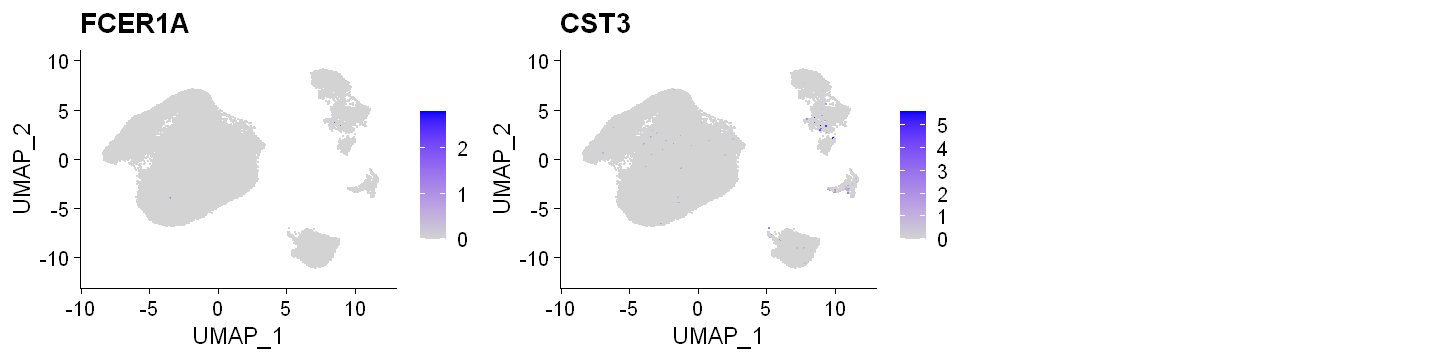

In [28]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = DC, ncol =3,cols = feature.cols, min.cutoff = 0)

### CD14 Monocyte

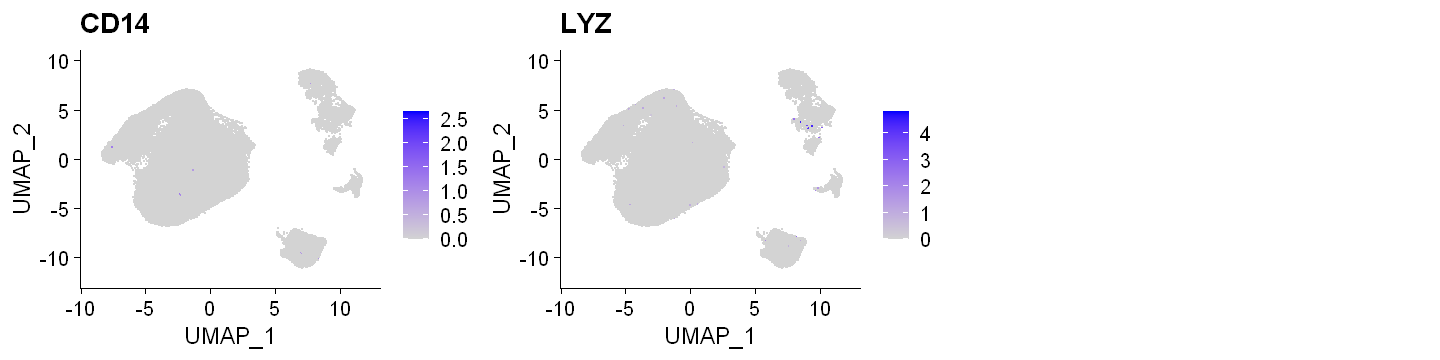

In [29]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = CD14.Monocyte, ncol =3,cols = feature.cols, min.cutoff = 0)

### Dividing cells

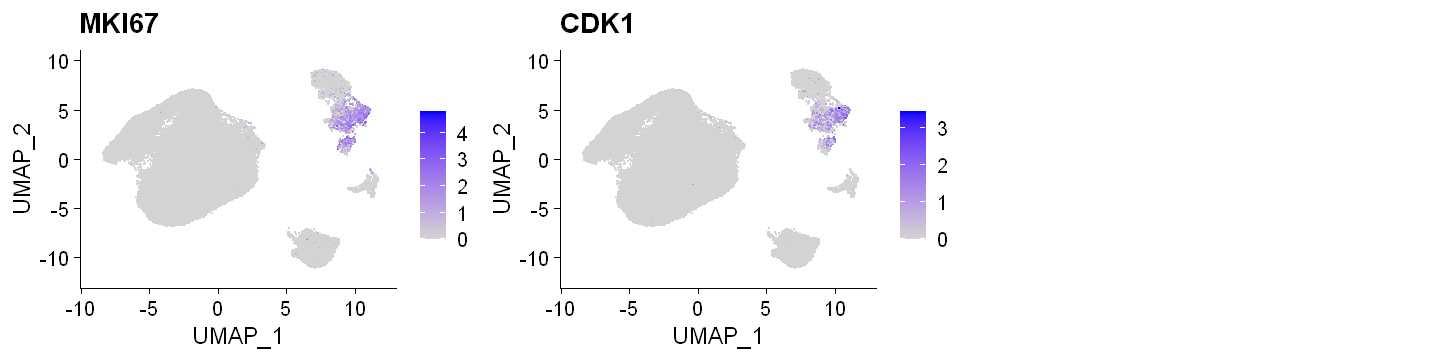

In [30]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = dividing, ncol =3,cols = feature.cols, min.cutoff = 0)

In [33]:
identities <- unique(Idents(immune.combined))
assignment_list <- list()
for(identity in identities){
    # mean expression of each gene in each cluster
    identity_cells <- data.frame(IDENTITY = Idents(immune.combined)) %>% 
        tibble::rownames_to_column("CELL") %>%
        filter(IDENTITY == identity) %>% select(CELL) %>% unlist()
    identity_obj <- subset(immune.combined, cells = identity_cells)
    #identity_mean_df <- data.frame(GetAssayData(object = identity_obj, slot = 'scale.data')) %>%
    #identity_mean_df <- data.frame(log(identity_obj@assays$RNA@counts+1) ) %>%
    identity_mean_df <- data.frame(identity_obj@assays$RNA@data) %>% # this data slot has normalized data
        tibble::rownames_to_column("GENE") %>%
        gather("CELL", "EXPR", -GENE) %>% 
        group_by(GENE) %>%
        summarize(EXPR_CLUSTER = mean(EXPR))
    
    # correlations of immunostate vectors with mean gene expression
    assignment_list[[identity]] <- immunostates %>%
        left_join(identity_mean_df, by="GENE") %>%
        drop_na(EXPR_CLUSTER) %>%
        filter(EXPR_CLUSTER != 0) %>%
        group_by(KNOWN) %>%
        summarize(COR = cor(EXPR,EXPR_CLUSTER))
}

In [34]:
assignment_df <- bind_rows(assignment_list, .id = "IDENTITY") %>% 
    group_by(IDENTITY) %>% 
    filter(COR == max(COR)) %>%
    arrange(as.numeric(IDENTITY))

assignment_df

IDENTITY KNOWN                          COR      
1  0        naive_B_cell                   0.6678698
2  1        naive_B_cell                   0.6565315
3  2        naive_B_cell                   0.6395878
4  3        naive_B_cell                   0.5576636
5  4        naive_B_cell                   0.6845251
6  5        naive_B_cell                   0.6072077
7  6        naive_B_cell                   0.5693782
8  7        naive_B_cell                   0.7041139
9  8        naive_B_cell                   0.7010375
10 9        CD4_positive_alpha_beta_T_cell 0.5633166
11 10       naive_B_cell                   0.6554457
12 11       naive_B_cell                   0.6831109
13 12       naive_B_cell                   0.6962813
14 13       CD8_positive_alpha_beta_T_cell 0.5643591
15 14       plasma_cell                    0.5927256
16 15       memory_B_cell                  0.6831416
17 16       naive_B_cell                   0.6742397
18 17       CD4_positive_alpha_beta_T_cell 0.7353289
19 18       naive_B_cell                   0.6624036
20 19       CD8_positive_alpha_beta_T_cell 0.5837787
21 20       CD8_positive_alpha_beta_T_cell 0.5748243

In [35]:
immune.combined = subset(immune.combined, idents = c(0,1,2,3,4,5,6,7,8,10,11,12,14,15,16,18))
saveRDS(immune.combined, file.path(path.work, "FNA_B_beforeAnnotation.GEX.rds"))

In [45]:
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR_Y1Y2","data")
BCR.Y1Y2.P04 = read.table(paste0(path.data, "/P04_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)
BCR.Y1Y2.P05 = read.table(paste0(path.data, "/P05_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

BCR.Y1Y2.P04 = BCR.Y1Y2.P04 %>% 
        dplyr::filter(SAMPLETYPE == "FNA" & DATATYPE == "singleCell") 
BCR.Y1Y2.P05 = BCR.Y1Y2.P05 %>% 
        dplyr::filter(SAMPLETYPE == "FNA" & DATATYPE == "singleCell") 
BCR.Y1Y2 = rbind(BCR.Y1Y2.P04, BCR.Y1Y2.P05)

BCR.Y1Y2$CELL = as.character(BCR.Y1Y2$CELL)
BCR.Y1Y2 = BCR.Y1Y2 %>% rowwise() %>%
            mutate(BARCODE = paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"))

Warning message in read.table(paste0(path.data, "/P04_p.tsv"), header = TRUE, sep = "\t", :
"not all columns named in 'as.is' exist"
Warning message in read.table(paste0(path.data, "/P05_p.tsv"), header = TRUE, sep = "\t", :
"not all columns named in 'as.is' exist"


In [61]:
match.index = match(Cells(immune.combined), BCR.Y1Y2$BARCODE)
immune.combined$contains_bcr = !is.na(match.index)
clone.id = BCR.Y1Y2$CLONE
immune.combined$bcr_clone_id = unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, clone.id[x])}))
mu.freq = BCR.Y1Y2$mu_freq
immune.combined$bcr_mu_freq = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, mu.freq[x])}))
isotype = as.character(BCR.Y1Y2$ISOTYPE) 
immune.combined$bcr_isotype = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, isotype[x])}))

In [63]:
unique(immune.combined$bcr_isotype)

[1] "IgM" NA    "IgD" "IgG" "IgA"

In [65]:
length(which(!is.na(match.index)))
umap1 = immune.combined@reductions$umap@cell.embeddings[,1]
umap2 = immune.combined@reductions$umap@cell.embeddings[,2]
GEX.meta = cbind(immune.combined[[]], cbind(umap1,umap2)) %>%
                dplyr::filter(contains_bcr)
colnames(GEX.meta)

[1] 77195

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "sampleName"     
 [5] "sampleName2"     "sampleType"      "day"             "subject"        
 [9] "percent.mt"      "RNA_snn_res.0.7" "seurat_clusters" "contains_bcr"   
[13] "bcr_clone_id"    "bcr_mu_freq"     "bcr_isotype"     "umap1"          
[17] "umap2"

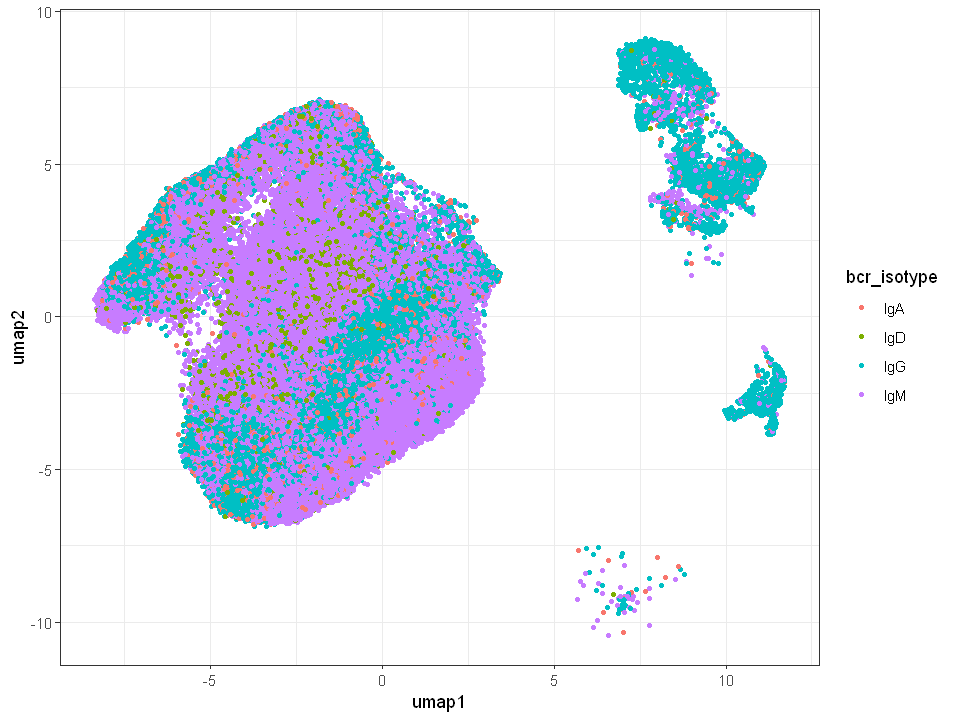

In [66]:
p.a = ggplot()+
    geom_point(data = GEX.meta, aes(x = umap1, y = umap2, color=bcr_isotype), size =1) +theme_bw()
options(repr.plot.width=8, repr.plot.height=6)    
plot(p.a)

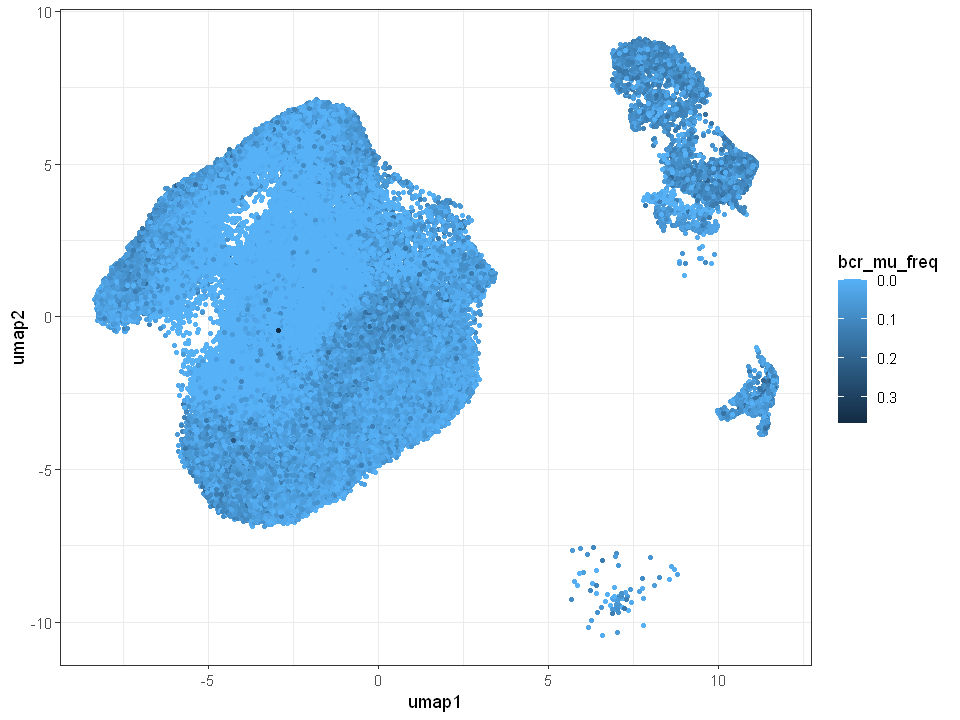

In [52]:
mut.max.freq = max(GEX.meta$bcr_mu_freq) # there is one outlier 0.61
GEX.meta = GEX.meta[-which(GEX.meta$bcr_mu_freq==mut.max.freq),]
p.b = ggplot()+
    geom_point(data = GEX.meta, aes(x = umap1, y = umap2, color=bcr_mu_freq), size =1) +
    theme_bw()+scale_colour_continuous(trans = 'reverse')
plot(p.b)

Warning message:
"Removed 13436 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 13436 rows containing missing values (geom_point)."


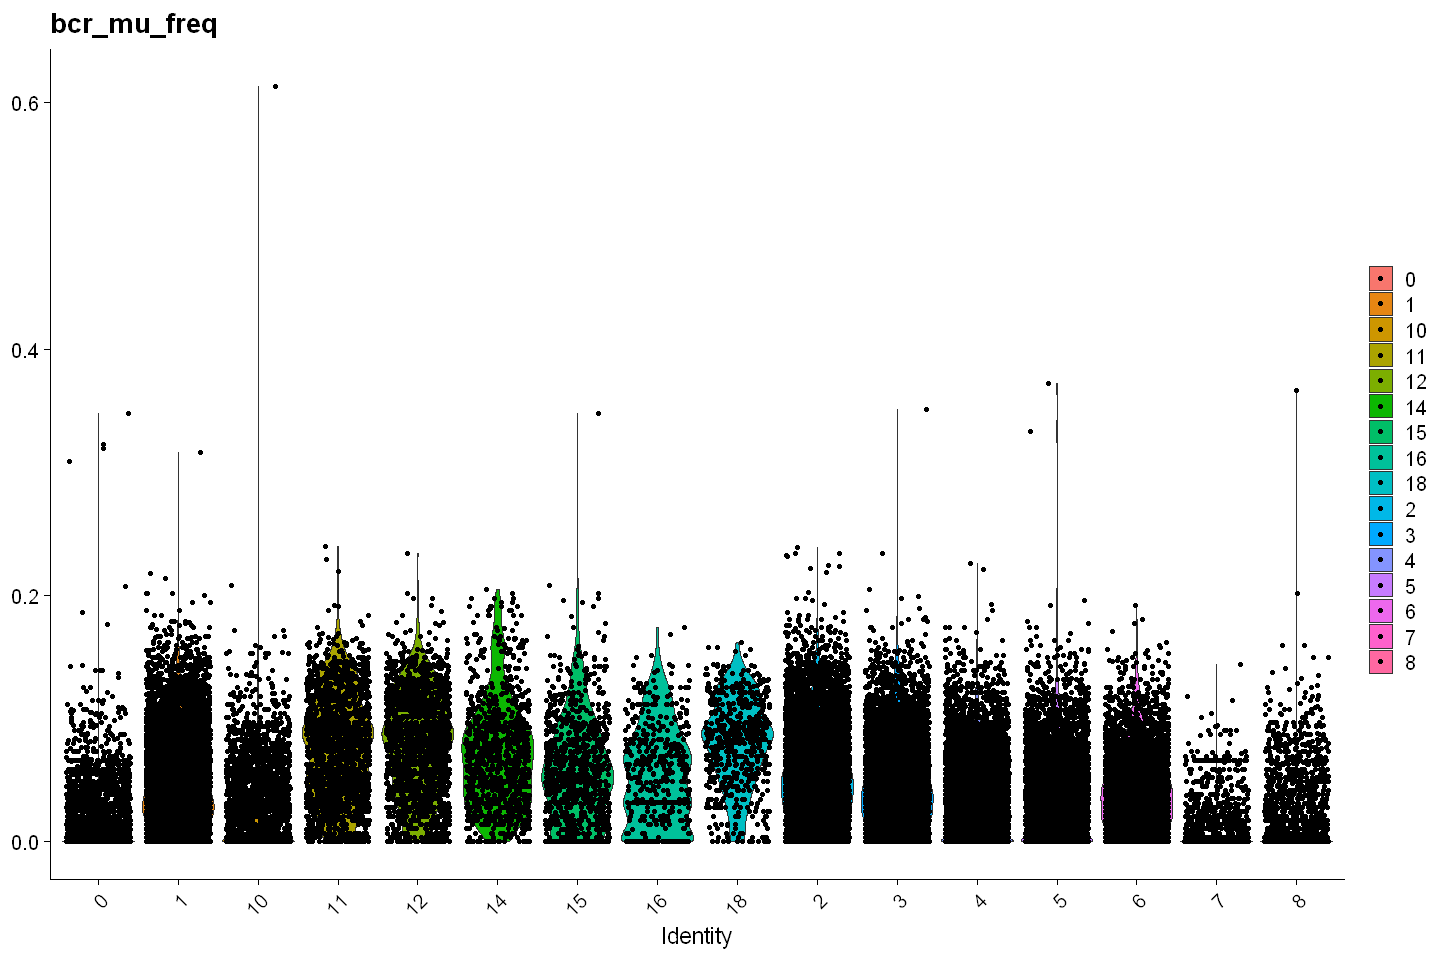

In [53]:
options(repr.plot.width=12, repr.plot.height=8)  
VlnPlot(immune.combined, features =  "bcr_mu_freq")

In [67]:
iso.data = data.frame(Isotype = immune.combined$bcr_isotype, 
                      Cluster=as.character(immune.combined$seurat_clusters),
                      stringsAsFactors = FALSE
                      )
#iso.data = dplyr::filter(iso.data, Cluster %in% c('0','1','2','3','4','5','6','8'))
a <- table(iso.data)
c <- prop.table(a, 1)
c
d <- data.frame(c)

       Cluster
Isotype            0            1           10           11           12
    IgA 0.0118898623 0.2044221944 0.0367125574 0.0110554860 0.0158531498
    IgD 0.4722433460 0.0418250951 0.0321926489 0.0020278834 0.0022813688
    IgG 0.0133840759 0.1994355597 0.0256136150 0.0650389122 0.0623449927
    IgM 0.2691812736 0.1589971156 0.0536942534 0.0040825383 0.0048812958
       Cluster
Isotype           14           15           16           18            2
    IgA 0.0095953275 0.0200250313 0.0081351690 0.0037546934 0.2438464748
    IgD 0.0005069708 0.0068441065 0.0017743980 0.0010139417 0.0344740177
    IgG 0.0388266484 0.0239031899 0.0137261610 0.0216796374 0.2290686736
    IgM 0.0018859552 0.0055913024 0.0030175283 0.0014865764 0.0913024185
       Cluster
Isotype            3            4            5            6            7
    IgA 0.1503963287 0.1211931581 0.0811430955 0.0657071339 0.0054234460
    IgD 0.0294043093 0.0942965779 0.0615969582 0.0248415716 0.0628643853
    Ig

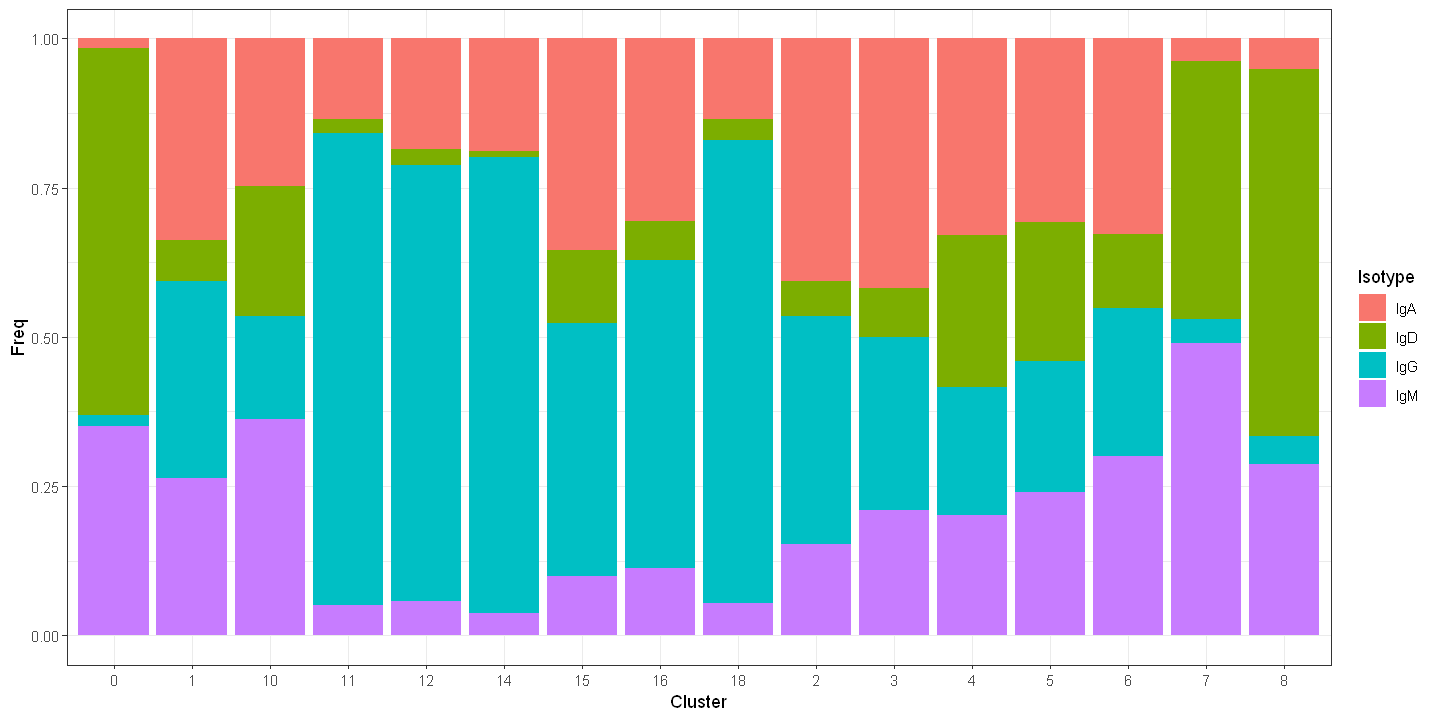

In [68]:
options(repr.plot.width=12, repr.plot.height=6) 
ggplot(d,aes(x = Cluster, y= Freq, fill = Isotype)) + 
  geom_bar(position = "fill", stat = "identity") +
  theme_bw()

In [36]:
unique(Idents(immune.combined))

[1] 0  1  10 11 12 14 15 16 18 2  3  4  5  6  7  8 
Levels: 0 1 10 11 12 14 15 16 18 2 3 4 5 6 7 8

In [77]:
immune.combined = readRDS(file.path(path.work, "FNA_B_beforeAnnotation.GEX.rds"))
levels(x = immune.combined)

[1] "0"  "1"  "10" "11" "12" "14" "15" "16" "18" "2"  "3"  "4"  "5"  "6"  "7" 
[16] "8"

In [80]:
#0,7,8,10: Naive
#11,12,18: GC
#15: ABC
#16 and the rest: RMB
#14:PB
new.cluster.ids <- c("Naive", "RMB","Naive", "GC","GC","PB","ABC",#0,1,10,11,12,14,15,
                     "RMB","GC","RMB", "RMB","RMB","RMB","RMB","Naive","Naive",# 16, 18,2,3,4,5,6,7,8  
                     "PB"#17
                    )
names(x = new.cluster.ids) <- levels(x = immune.combined)
immune.combined <- RenameIdents(object = immune.combined, new.cluster.ids)

Warning message:
"Cannot find identity NA"


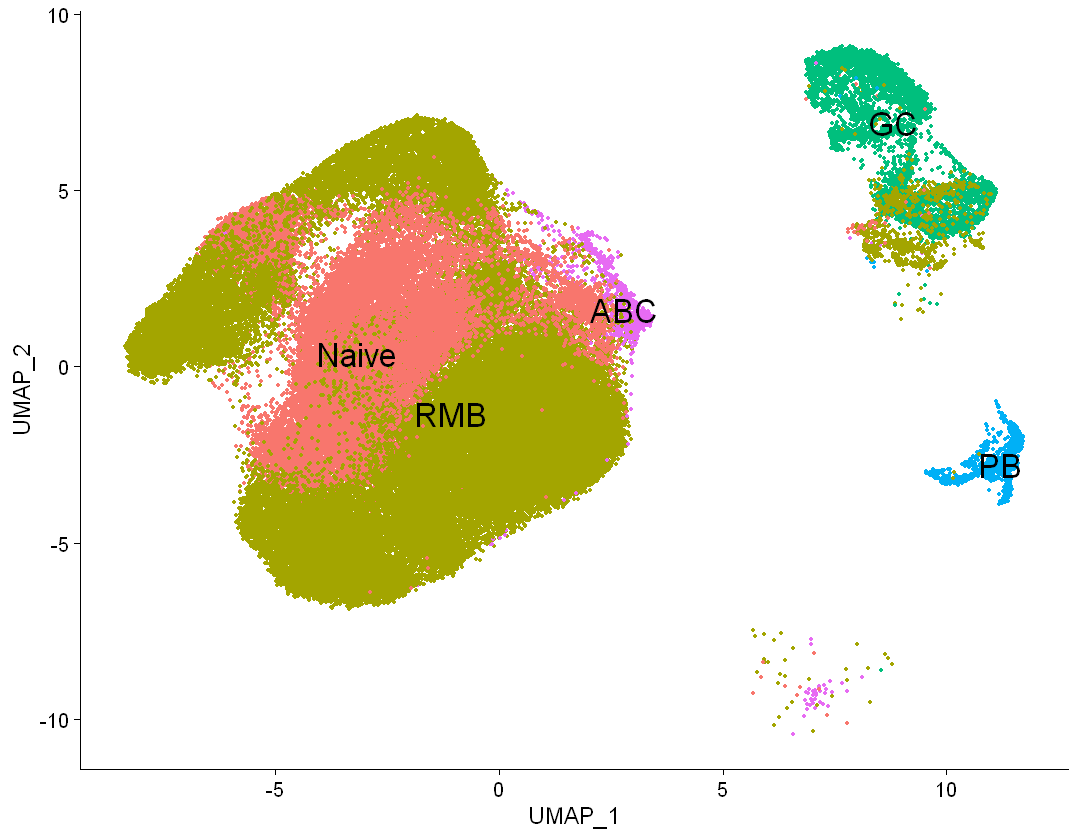

In [81]:
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE, pt.size = 0.8,label.size=7) + NoLegend()

In [82]:
# save for future use
saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,"_B.GEX.rds")))

In [ ]:
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC))
options(repr.plot.width=12, repr.plot.height=3)
DotPlot(immune.combined, assay = "RNA", features =  unique(all.markers), dot.scale = 8) + RotatedAxis()

In [ ]:
length(immune.combined@active.ident)
table(Idents(immune.combined))
table(immune.combined$sampleType)
prop.table(table(Idents(immune.combined),immune.combined$sampleType))
#prop.table(table(Idents(immune.combined)))

In [ ]:
head(immune.combined[[]])
rownames(immune.combined[[]])[1:10]